In [131]:
import TimeSliceImport
import numpy as np
import keras
import random
import gc
from keras.models import Sequential

from keras.layers import (Dense, Dropout, Activation, Conv1D,Concatenate, Flatten)
from keras.layers import (MaxPooling1D,BatchNormalization,LocallyConnected1D, SeparableConv1D,LeakyReLU)
from keras.activations import (tanh,softmax)
from keras.optimizers import SGD
from sklearn import (metrics,preprocessing)
import RamanPlotTools as pt
import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
from mpl_toolkits import mplot3d
from keras.optimizers import Adam
from keras.backend import tensorflow_backend as backend
from keras import backend as K
print(backend.device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 178051146074779568
]


In [122]:
# path="/home/waseda/Desktop/shared/SKYP_KYP_SYP"
path="/Users/morten/Desktop/SKYP_KYP_SYP/"
outPath="/Users/morten/Desktop/SKYP_KYP_SYP/models"
# outPath="/home/waseda/Desktop/models/"

numClasses=4
types=["PS", "yeast","spore","kleb"]
allData=TimeSliceImport.importData(path,types)
classes=list(map(lambda x:TimeSliceImport.RamanSample.mappings[x],types))
sortedTypesTuples=sorted(zip(types,classes),key=lambda x:x[1])
sortedTypes=[x[0] for x in sortedTypesTuples]

startPNT=201

def scaleSampleSpectra(sampleSpectra,scalePer="spectrum",scaleMethod="scale"):
    scaledSampleSpectra=None
    if scalePer == "spectrum":
        if scaleMethod == "scale":
            scaledSampleSpectra=preprocessing.minmax_scale(sampleSpectra,axis=0)
        elif scaleMethod == "standardize":
            scaledSampleSpectra=preprocessing.scale(sampleSpectra,axis=0)
    elif scalePer == "sample":
        if scaleMethod == "scale":
            minV=np.min(sampleSpectra)
            maxV=np.max(sampleSpectra)
            scaledSampleSpectra=(sampleSpectra-minV)/(maxV-minV)
            
        elif scaleMethod == "standardize":
            mean=np.mean(sampleSpectra)
            scaledSampleSpectra=sampleSpectra-mean
            sDev=np.std(scaledSampleSpectra)
            scaledSampleSpectra/=sDev
    return scaledSampleSpectra


def makeRandomData(split=0.25,filter="NONE",start=startPNT,end=2500,points=1024,removeBG=False, scalePer="spectrum",scaleMethod="scale",spectraAsChannels=True):
    trainingSamples, validationSamples = TimeSliceImport.splitData(allData, split)
    
    def processSample(sample):
        sampleSpectra,sampleClasses=sample.interpolatedSpectra(start, end, points, filter=filter,removeBackground=removeBG)
        oneHotSampleClasses=keras.utils.to_categorical(sampleClasses,num_classes=numClasses)    
        if spectraAsChannels is True:
            scaledSpectra=scaleSampleSpectra(sampleSpectra,scalePer=scalePer,scaleMethod=scaleMethod) 
        else:
            scaledSpectra=np.transpose(scaleSampleSpectra(sampleSpectra,scalePer=scalePer,scaleMethod=scaleMethod))
        return scaledSpectra,oneHotSampleClasses
    
    trainingSpectra=[]
    trainingClasses=[]
    validationSpectra=[]
    validationClasses=[]
    
    for sample in trainingSamples:
        s,c=processSample(sample)
        trainingClasses.append(c[0])
        trainingSpectra.append(s)
        
    for sample in validationSamples:
        s,c=processSample(sample)
        validationClasses.append(c[0])
        validationSpectra.append(s)
  
    return np.array(trainingSpectra),np.array(trainingClasses),np.array(validationSpectra),np.array(validationClasses)




def scalarClassesFromOneHotArray(oneHotArray):
    return np.argmax(oneHotArray,axis=1)

def plotResult(truth,result, score, normalize=False):
    pt.plotResult(scalarClassesFromOneHotArray(result),scalarClassesFromOneHotArray(truth),sortedTypes)
    mtrx = metrics.confusion_matrix(scalarClassesFromOneHotArray(truth),scalarClassesFromOneHotArray(result))
    pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % score, normalize=normalize)

def plotLearning(history):
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training Loss', 'Cross-Validation Loss'])
    plt.show()

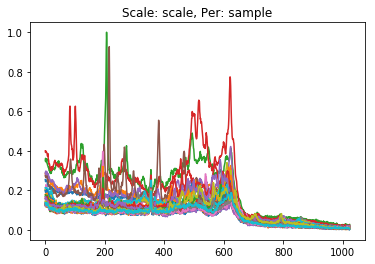

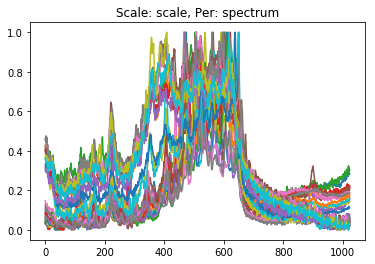

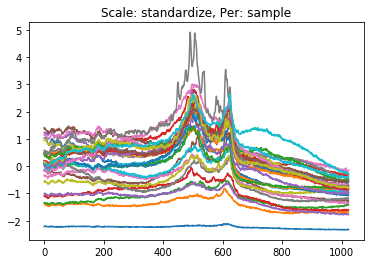

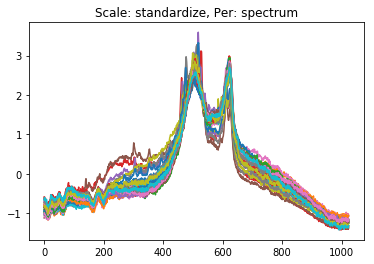

In [124]:
for method in ["scale","standardize"]:
    for per in ["sample","spectrum"]:
        xTrain,yTrain,xTest,yTest=makeRandomData(spectraAsChannels=False,scaleMethod=method,scalePer=per)
        
        firstSample=xTrain[0]
        for spectrum in firstSample:
            plt.plot(spectrum)
        plt.title("Scale: {}, Per: {}".format(method,per))
        plt.show()

glassAg_KYP_kleb_13.txt


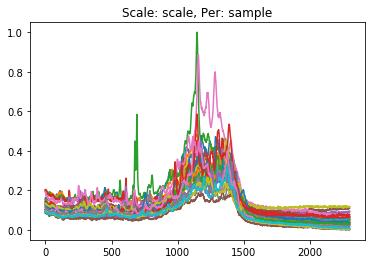

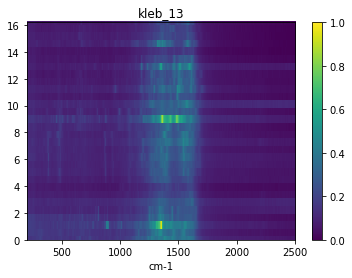

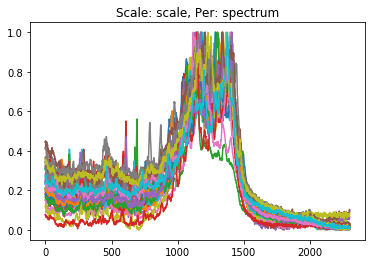

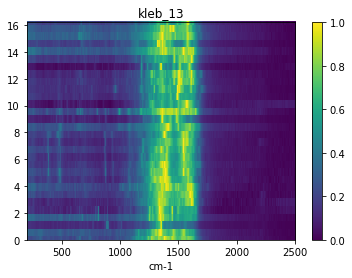

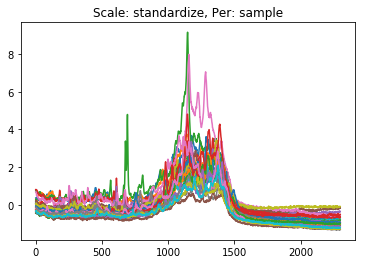

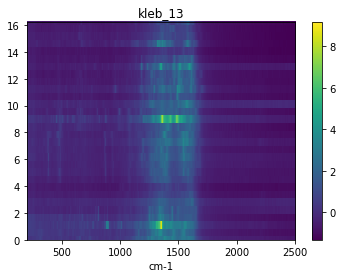

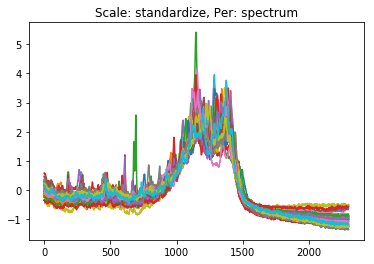

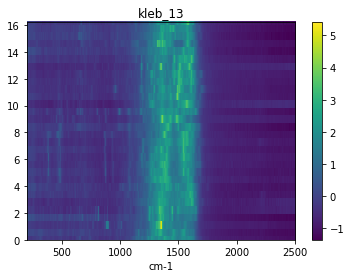

In [125]:
randomSample=random.choice(allData)
print(randomSample.name)
endPNT=2500
spectra,classes=randomSample.interpolatedSpectra(startPNT, end=endPNT, points=endPNT-startPNT)
x = np.linspace(startPNT,endPNT,endPNT-startPNT)
y = np.copy(randomSample.times)
for method in ["scale","standardize"]:
    for per in ["sample","spectrum"]:
        z=scaleSampleSpectra(spectra,scalePer=per,scaleMethod=method).T
        for spectrum in z:
            plt.plot(spectrum)
        plt.title("Scale: {}, Per: {}".format(method,per))
        plt.show()
        
        fig,ax=plt.subplots()
        minX=np.min(x)
        maxX=np.max(x)
        minY=np.min(y)
        maxY=np.max(y)
        im = NonUniformImage(ax, interpolation="nearest",extent=(minX,maxX,minY,maxY))
        im.set_data(x, y, z)
        ax.images.append(im)
        ax.set_xlim(minX, maxX)
        ax.set_ylim(minY, maxY)
        label=randomSample.prettyName()

        ax.set_title(label)
        ax.set_xlabel("cm-1")
        plt.colorbar(im)
        plt.show()

In [138]:
def makeModelCNN(batchNormalize=False,inputShape=(100,1),separable=(0,0,0),kernelSize=(21,11,5)):
    model = Sequential()
    if separable[0] == 0:
        model.add(Conv1D(16,kernelSize[0], input_shape=inputShape))
    else:
        model.add(SeparableConv1D(16,kernelSize[0], input_shape=inputShape,depth_multiplier=separable[0]))  
    
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU())
    model.add(MaxPooling1D(2,2))
    
    if separable[1] == 0:
        model.add(Conv1D(32,kernelSize[1]))
    else:
        model.add(SeparableConv1D(32,kernelSize[1],depth_multiplier=separable[1]))
        
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU())
    model.add(MaxPooling1D(2,2))
    
    if separable[2] == 0:
        model.add(Conv1D(64,kernelSize[2]))
    else:
       model.add(SeparableConv1D(64,kernelSize[2],depth_multiplier=separable[2]))
        
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU())
    model.add(MaxPooling1D(2,2))
    
    model.add(Flatten())
    model.add(Dense(2048))
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(Activation("tanh"))
    # model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))
   
    model.add(Dense(numClasses))
    if batchNormalize is True:
        model.add(BatchNormalization())
    model.add(Activation("softmax"))
        
    model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [141]:
def runModelCNN(numRepetitions=1):
    scores=[]
    labels=[]
   
    
    for normalize in [False,True]:
        for method in ["scale","standardize"]:
            for per in ["sample","spectrum"]:
        
                for separable in [(0,0,0),(1,1,1),(2,2,2),(4,4,4)]:
                    runScores=[]
                    results=[]
                    truths=[]
                    label="{},{}\n{},{}".format(method,per,str(normalize),str(separable))
                    labels.append(label)
                    print(label)
                    
                    for i in range(numRepetitions):
                        
                        rangeEnd=2500
                        dist=rangeEnd-startPNT
                    
                        xTrain, yTrain, xTest, yTest=makeRandomData(scalePer=per,scaleMethod=method,
                                                                    end=rangeEnd,points=dist,
                                                                    spectraAsChannels=True)
                        print(xTest.shape)
                        inputShape=(xTrain.shape[1],xTrain.shape[2])
                        print(inputShape)
                        model=makeModelCNN(batchNormalize=normalize,inputShape=inputShape,separable=separable)
                        
                        if i==0:
                            print(model.summary())
                
                        history = model.fit(xTrain, yTrain, epochs=1, validation_split=0.05, verbose=50,batch_size=4)
                        score = model.evaluate(xTest, yTest)
                        prd = model.predict(xTest)
                        
                        skScore=metrics.accuracy_score(scalarClassesFromOneHotArray(yTest),scalarClassesFromOneHotArray(prd))
                        print("Score: {}, SKScore: {}".format(score[1], skScore))
                        print(skScore)
                        results.extend(scalarClassesFromOneHotArray(prd))
                        runScores.append(skScore)
                        truths.extend(scalarClassesFromOneHotArray(yTest))
                        plt.plot(history.history['acc'], color='blue')
                        plt.plot(history.history['val_acc'], color='orange')
                        
                        K.clear_session()
                        del history
                        del model
                        gc.collect()
                    
                    avgScore=sum(runScores)/float(len(runScores))
                    print("Score: {}".format(avgScore))
                    plt.title('model accuracy')
                    plt.ylabel('accuracy')
                    plt.xlabel('epoch')
                    plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
                    plt.show()
                    scores.append(runScores)
                    pt.plotResult(results,truths,sortedTypes)
                    mtrx = metrics.confusion_matrix(truths,results)
                    pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % avgScore, normalize=True)
    
    npScores=np.array(scores)
    
    return labels,npScores

In [142]:
label,score=runModelCNN(numRepetitions=5)
plt.boxplot(np.transpose(scores), labels=labels, showmeans=True)
plt.xticks(rotation=90)
plt.show()

False,(1, 1, 1)


(21, 30, 2299)
(30, 2299)


ValueError: Negative dimension size caused by subtracting 11 from 5 for 'separable_conv1d_17/separable_conv2d/depthwise' (op: 'DepthwiseConv2dNative') with input shapes: [?,1,5,16], [1,11,16,1].

In [ ]:
def data(index,start=startPNT,end=1600,points=1000,filter="NONE",scalePer="spectrum",scaleMethod="scale",spectraAsChannels=True):
    
    validationSample=spectra[index].copy()
    validationSamples=[validationSample]
    
    trainingSamples=spectra.copy()
    trainingSamples.pop(index)
    
    def processSample(sample):
        sampleSpectra,sampleClasses=sample.interpolatedSpectra(start, end, points,filter=filter)
        oneHotSampleClasses=keras.utils.to_categorical(sampleClasses,num_classes=numClasses)    
        if spectraAsChannels is True:
            scaledSpectra=scaleSampleSpectra(sampleSpectra,scalePer=scalePer,scaleMethod=scaleMethod) 
        else:
            scaledSpectra=np.transpose(scaleSampleSpectra(sampleSpectra,scalePer=scalePer,scaleMethod=scaleMethod))
        return scaledSpectra,oneHotSampleClasses
    
    trainingSpectra=[]
    trainingClasses=[]
    validationSpectra=[]
    validationClasses=[]
    
    for sample in trainingSamples:
        s,c=processSample(sample)
        trainingClasses.append(c[0])
        trainingSpectra.append(s)
        
    for sample in validationSamples:
        s,c=processSample(sample)
        validationClasses.append(c[0])
        validationSpectra.append(s)
    
    return np.array(trainingSpectra),np.array(trainingClasses),np.array(validationSpectra),np.array(validationClasses)

def plotPie(truths,results):
    correct=np.zeros(numClasses)
    unique, counts=np.unique(results,return_counts=True)
    
    for ct in zip(unique,counts):
        correct[ct[0]]=ct[1]/len(results)
        
    labels="spore","kleb","PS","yeast"
    leftOutIndex=int(np.array(truths).mean())
    
    explode=np.zeros(len(correct))
    explode[leftOutIndex]=0.1
    applicapleLables=labels[:len(correct)]
    
    plt.pie(correct,explode=explode,labels=applicapleLables,autopct='%1.0f%%')
    plt.show()
    return correct

def makeBarPlot(labels,scores):
    cleanLabels=list(map(lambda label:"_".join(label.split(".")[0].split("_")[2:]),labels))
    result=list(zip(cleanLabels,np.squeeze(scores)))

    sortedResult=sorted(result,key=lambda l:(l[0].split("_")[0],int(l[0].split("_")[1])))

    values=list(map(lambda r:r[1],sortedResult))
    keys=list(map(lambda r:r[0],sortedResult))
    plt.figure(figsize=(20,8))
    plt.bar(keys,values)
    plt.xticks(rotation=90)
    plt.show()
    print("Mean: {}".format(np.array(values).mean()))
    return values
    
def makeProbPlot(sampleScoresDict,globalAverages):
    cleanList=[]
    for key in sampleScoresDict:
        cleanKey="_".join(key.split(".")[0].split("_")[2:])
        entries=sampleScoresDict[key]
        percEntries=entries/np.sum(entries)
        r=np.zeros(numClasses)
        r[:percEntries.shape[0]] = percEntries
        cleanList.append((cleanKey,r))
    
    sortedResult=sorted(cleanList,key=lambda l:(l[0].split("_")[0],int(l[0].split("_")[1])))
    # print(sortedResult)
    
    percentValues=(list(map(lambda r:np.asarray(r[1]),sortedResult)))
    keys=list(map(lambda r:r[0],sortedResult))
    
    previousSum=np.zeros(len(percentValues))
    plots=[]
    plt.figure(figsize=(20,8))
    for idx in range(numClasses):
        currentValues=list(map(lambda r:r[idx],percentValues))
        p=plt.bar(keys,currentValues,bottom=previousSum)
        previousSum+=currentValues
        plots.append(p)
        
    plt.xticks(rotation=90)
    plt.legend(plots,("spore","kleb","PS","yeast"),loc="right")
    plt.plot(keys,globalAverages,color="k",linestyle="-",marker="o")
    plt.show()



In [ ]:
def runModelLOO(filter="NONE",rangeEnd=2500):
    
    scores=[]
   
    labels=[]
    
    end=range(len(spectra))
    #end=range(10)
    sampleScores={}
    per="sample"
    method="scale"
    normalize=False
    separable=(1,1,1)
    for idx in end:
        
        runScores=[]
        results=[]
        truths=[]
        currentSample=allData[idx]
        print("Leaving Out {}".format(currentSample.name))
         
        label="{}".format(currentSample.name)
        labels.append(label)
        
        dist=rangeEnd-startPNT
    
        xTrain, yTrain, xTest, yTest=makeRandomData(scalePer=per,scaleMethod=method,
                                                                    end=rangeEnd,points=dist,
                                                                    spectraAsChannels=True)
        
        inputShape=(xTrain.shape[1],xTrain.shape[2])
        model=makeModelCNN(batchNormalize=normalize,inputShape=inputShape,separable=separable)
        
        
        if idx==0:
            print(model.summary())

        history = model.fit(xTrain, yTrain, epochs=100, validation_split=0.05, verbose=0)
        score = model.evaluate(xTest, yTest)
        prd = model.predict(xTest)
         
        skScore=metrics.accuracy_score(scalarClassesFromOneHotArray(yTest),scalarClassesFromOneHotArray(prd))
        
        print("Score: {}, SKScore: {}".format(score[1], skScore))
        
        results.extend(scalarClassesFromOneHotArray(prd))
        runScores.append(skScore)
        truths.extend(scalarClassesFromOneHotArray(yTest))
        plt.plot(history.history['acc'], color='blue')
        plt.plot(history.history['val_acc'], color='orange')
        
        avgScore=sum(runScores)/float(len(runScores))
        print("Score: {}".format(avgScore))
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
        plt.show()
        scores.append(runScores)
        # print(results) 
        sampleScore=plotPie(truths,results)
        sampleScores[label]=sampleScore
        
        K.clear_session()
        del history
        del model
        gc.collect()
        
        
    npScores=np.array(scores)

    
    return labels,npScores,sampleScores

In [ ]:
labels,scores,sampleScoresDict=runModelLOO()

In [ ]:
values=makeBarPlot(labels,scores)
makeProbPlot(sampleScoresDict,values)